# 🧠 Anomaly Detection — Emisi CO₂ (Indonesia & Global)

Notebook ini mendeteksi **anomali** pada deret waktu emisi:
- **CO₂ (excl. LUC)** dan **CO₂ (incl. LUC)** Indonesia  
- (Opsional) Global/negara lain

Metode:
1. **Rolling band (μ±k·σ)** → deteksi deviasi lokal.
2. **ESD/Grubbs** → deteksi outlier global berulang.

Output:
- Grafik anomali (.png)
- Tabel anomali (.csv)
- Markdown interpretasi singkat


# =========================
# 0) Setup & load data
# =========================

In [1]:
# 0) Setup & load
import os, sys, numpy as np, pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import IsolationForest

# Path data (ganti jika perlu)
DATA_PATH = "/kaggle/input/clean-dataset-co2-1/co2_country_clean.csv"  # hasil EDA sebelumnya
assert os.path.exists(DATA_PATH), f"File tidak ditemukan: {DATA_PATH}"

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__, "| numpy:", np.__version__, "| matplotlib:", matplotlib.__version__)
print("DATA_PATH:", DATA_PATH)

def savefig(path, dpi=140, bbox_inches="tight"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=dpi, bbox_inches=bbox_inches)

df = pd.read_csv(DATA_PATH)
if "year" in df.columns:
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# Fokus negara
COUNTRY = "Indonesia"

# Kolom metrik utama (gunakan yang tersedia)
METRICS = [c for c in ["co2", "co2_including_luc"] if c in df.columns]
print("Metrics tersedia:", METRICS)


Python: 3.11.13
pandas: 2.2.3 | numpy: 1.26.4 | matplotlib: 3.7.2
DATA_PATH: /kaggle/input/clean-dataset-co2-1/co2_country_clean.csv
Metrics tersedia: ['co2', 'co2_including_luc']


## 🎯 Seri Waktu yang Dipakai

- **co2** → CO₂ *excl. LUC*  
- **co2_including_luc** → CO₂ *incl. LUC* (menghitung perubahan lahan)  

Fokus ke **Indonesia**, lalu sediakan fungsi untuk negara lain atau *World*.


# =========================
# 1) Siapkan seri waktu (Indonesia)
# =========================

In [2]:
def get_series(df_all, country, metric):
    d = (df_all[(df_all["name"]==country)]
         .dropna(subset=["year"])
         .sort_values("year")[["year", metric]].dropna())
    # Jaga-jaga: kalau ada dupe per year, ambil rata-rata
    d = d.groupby("year", as_index=False)[metric].mean()
    d = d.set_index("year")[metric].astype(float)
    return d

series_map = {}
for m in METRICS:
    ser = get_series(df, COUNTRY, m)
    series_map[m] = ser
    print(f"{COUNTRY} — {m}: {ser.index.min()}–{ser.index.max()}, n={ser.shape[0]}")


Indonesia — co2: 1889–2023, n=135
Indonesia — co2_including_luc: 1889–2023, n=135


## 🧪 Metode 1: Rolling Band (μ ± k·σ)

- Hitung **rata-rata bergulir** dan **simpangan baku bergulir** (window `w` tahun).
- Titik dianggap anomali jika **di luar** pita μ±k·σ.  
- Umum dipakai untuk “shift & spike” di deret waktu.


# =========================
# 2) Rolling band anomalies
# =========================

## 2) Metode A — Rolling Band (µ ± k·σ)
Logika:
- Hitung **rata-rata** & **deviasi standar** bergerak (window `w`)
- Titik dianggap anomali jika di luar **[µ − k·σ, µ + k·σ]**
- Pilih parameter: `window=5` tahun, `k=2.5` (bisa diubah)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


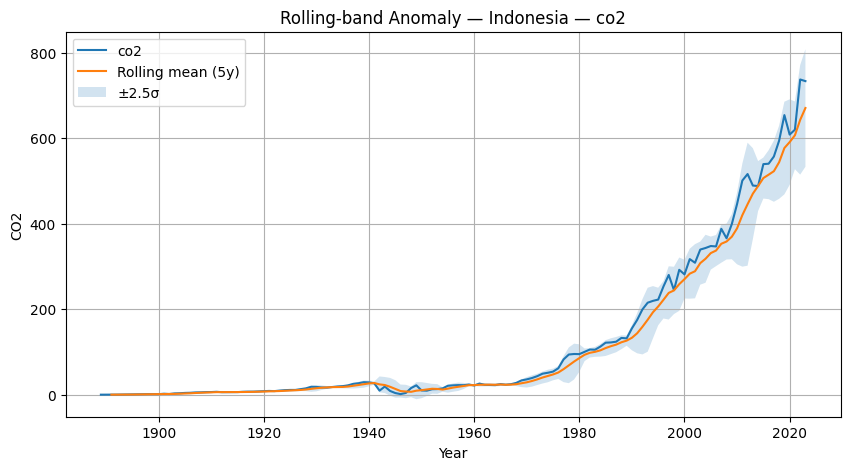

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


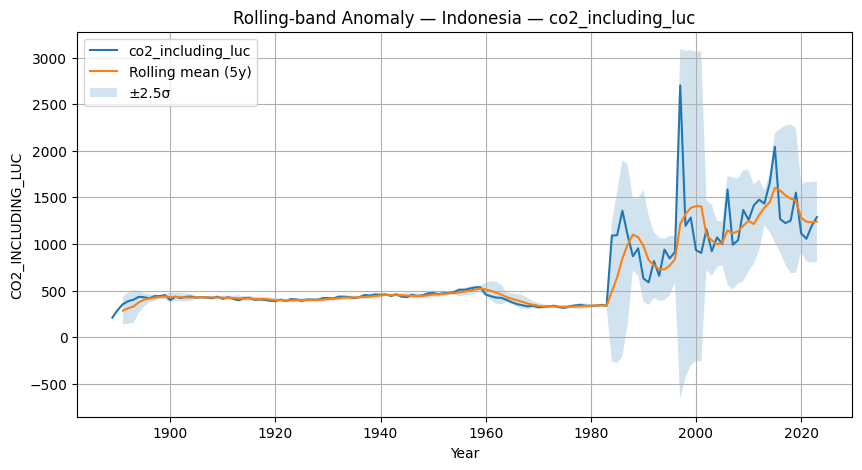

Anomali (Rolling) — Indonesia — co2


,year,value,mean,upper,lower,is_anomaly


Anomali (Rolling) — Indonesia — co2_including_luc


,year,value,mean,upper,lower,is_anomaly


In [3]:
def rolling_band_anomaly(ser: pd.Series, window=5, k=2.5, min_periods=3):
    ser = ser.copy().astype(float)
    mu = ser.rolling(window, min_periods=min_periods).mean()
    sd = ser.rolling(window, min_periods=min_periods).std(ddof=0)
    upper = mu + k*sd
    lower = mu - k*sd
    is_anom = (ser > upper) | (ser < lower)
    out = pd.DataFrame({
        "year": ser.index.astype(int),
        "value": ser.values,
        "mean": mu.values,
        "upper": upper.values,
        "lower": lower.values,
        "is_anomaly": is_anom.values
    }).dropna(subset=["value"])
    return out

os.makedirs("reports/figures", exist_ok=True)
os.makedirs("reports/tables", exist_ok=True)

rb_results = {}
for m, ser in series_map.items():
    rb = rolling_band_anomaly(ser, window=5, k=2.5, min_periods=3)
    rb_results[m] = rb
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(rb["year"], rb["value"], label=m)
    plt.plot(rb["year"], rb["mean"], label=f"Rolling mean (5y)")
    plt.fill_between(rb["year"], rb["lower"], rb["upper"], alpha=0.2, label="±2.5σ")
    an = rb[rb["is_anomaly"]]
    if not an.empty:
        plt.scatter(an["year"], an["value"], s=35)
    plt.title(f"Rolling-band Anomaly — {COUNTRY} — {m}")
    plt.xlabel("Year"); plt.ylabel(m.upper())
    plt.grid(True); plt.legend()
    savefig(f"reports/figures/rolling_band_{COUNTRY.lower()}_{m}.png")
    plt.show()
    
    # Simpan CSV anomali
    rb[rb["is_anomaly"]].to_csv(f"reports/tables/anomalies_rolling_{COUNTRY.lower()}_{m}.csv", index=False)

for m in METRICS:
    print(f"Anomali (Rolling) — {COUNTRY} — {m}")
    display(rb_results[m][rb_results[m]["is_anomaly"]].sort_values("year"))


## 3) Metode B — Generalized ESD (Iterative Grubbs’ Test)
- Iteratif mendeteksi titik ter-ekstrem (outlier) hingga `max_outliers` atau tidak signifikan lagi.
- Cocok untuk deret pendek/tahunan
- Parameter: `alpha=0.05`, `max_outliers=10` (bisa diubah)


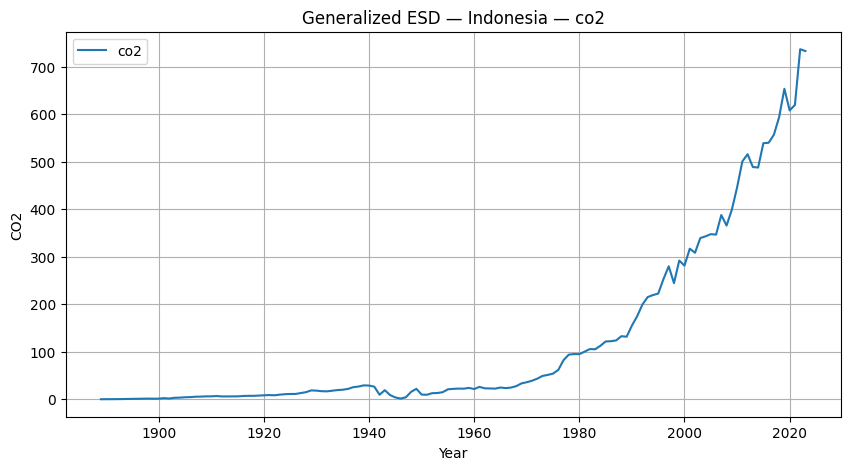

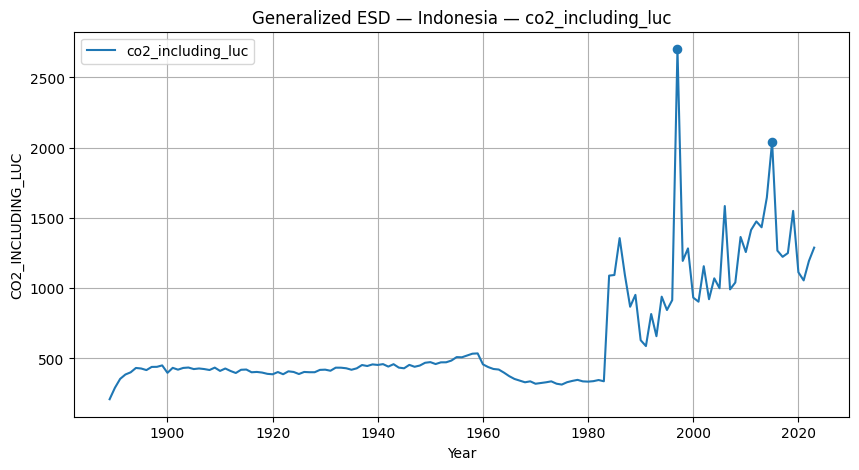

Anomali (ESD) — Indonesia — co2


,year,value,is_outlier


Anomali (ESD) — Indonesia — co2_including_luc


,year,value,is_outlier
108,1997,"2,701.2120",True
126,2015,"2,042.7260",True


In [4]:
def generalized_esd(series: pd.Series, alpha=0.05, max_outliers=10):
    # Implementasi ringkas ESD (Grubbs iteratif)
    x = series.dropna().astype(float).copy()
    idx = x.index.values
    values = x.values
    outlier_idx = []
    
    for i in range(1, min(max_outliers, len(values)-2) + 1):
        mean = values.mean()
        sd = values.std(ddof=1)
        if sd == 0:
            break
        # skor maksimum
        diffs = np.abs(values - mean)
        max_i = np.argmax(diffs)
        R = diffs[max_i] / sd
        
        # kritikal Grubbs
        n = len(values)
        tcrit = stats.t.ppf(1 - alpha/(2*n), n-2)
        Gcrit = ((n-1)/np.sqrt(n)) * np.sqrt(tcrit**2 / (n-2 + tcrit**2))
        
        if R > Gcrit:
            outlier_idx.append(idx[max_i])
            # buang titik itu dan lanjut
            values = np.delete(values, max_i)
            idx = np.delete(idx, max_i)
        else:
            break
    
    res = pd.DataFrame({
        "year": series.index.astype(int),
        "value": series.values,
        "is_outlier": series.index.isin(outlier_idx)
    })
    return res

esd_results = {}
for m, ser in series_map.items():
    esd = generalized_esd(ser, alpha=0.05, max_outliers=10)
    esd_results[m] = esd
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(esd["year"], esd["value"], label=m)
    out = esd[esd["is_outlier"]]
    if not out.empty:
        plt.scatter(out["year"], out["value"], s=35)
    plt.title(f"Generalized ESD — {COUNTRY} — {m}")
    plt.xlabel("Year"); plt.ylabel(m.upper())
    plt.grid(True); plt.legend()
    savefig(f"reports/figures/esd_{COUNTRY.lower()}_{m}.png")
    plt.show()
    
    # Simpan CSV
    esd[esd["is_outlier"]].to_csv(f"reports/tables/anomalies_esd_{COUNTRY.lower()}_{m}.csv", index=False)

for m in METRICS:
    print(f"Anomali (ESD) — {COUNTRY} — {m}")
    display(esd_results[m][esd_results[m]["is_outlier"]].sort_values("year"))


## 4) Metode C — Isolation Forest pada Fitur Perubahan
- Fitur: perubahan **∆** dan **%∆** year-over-year (YOY)
- Model **unsupervised** menilai titik “asing” dibanding pola umum
- Cocok untuk mendeteksi **pergeseran mendadak**


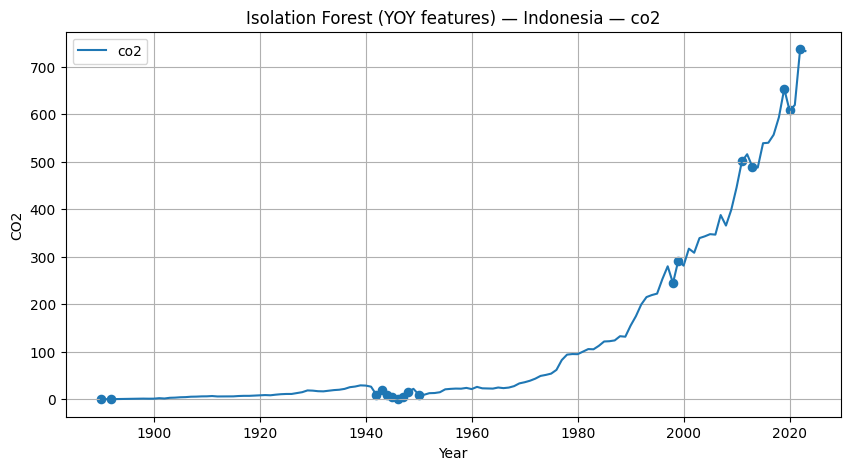

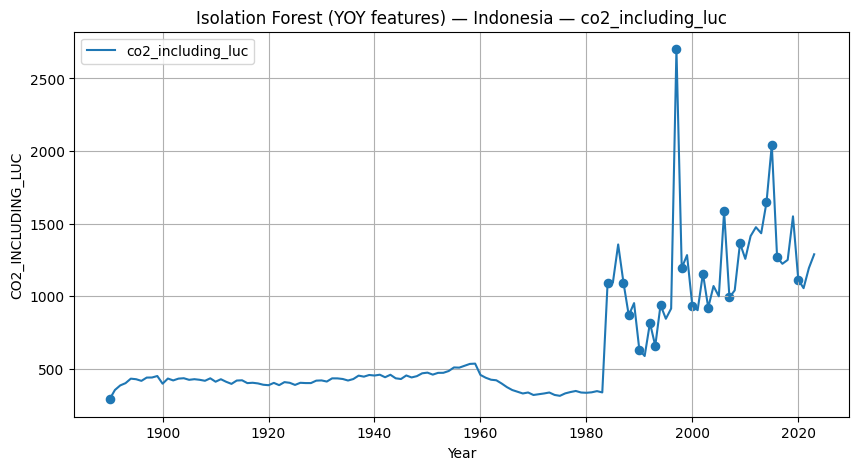

Anomali (IsolationForest) — Indonesia — co2


,year,value,diff,pct,if_score
1,1890,0.0150,0.0110,2.7500,-0.1260
3,1892,0.1910,0.1690,7.6818,-0.3034
53,1942,9.4570,-17.0290,-0.6429,-0.0991
54,1943,19.0270,9.5700,1.0119,-0.0596
55,1944,8.7720,-10.2550,-0.5390,-0.0228
56,1945,3.8070,-4.9650,-0.5660,-0.0153
57,1946,1.3450,-2.4620,-0.6467,-0.0370
58,1947,4.0560,2.7110,2.0156,-0.0981
59,1948,15.4950,11.4390,2.8203,-0.1766
61,1950,9.8310,-12.0720,-0.5512,-0.0331


Anomali (IsolationForest) — Indonesia — co2_including_luc


,year,value,diff,pct,if_score
1,1890,290.8970,80.9320,0.3855,-0.0670
95,1984,"1,089.7400",752.0190,2.2267,-0.3009
98,1987,"1,094.1020",-262.5620,-0.1935,-0.0308
99,1988,868.2870,-225.8150,-0.2064,-0.0148
101,1990,630.1780,-322.5960,-0.3386,-0.0894
103,1992,816.5650,228.2850,0.3881,-0.0466
104,1993,658.4670,-158.0980,-0.1936,-0.0186
105,1994,939.9200,281.4530,0.4274,-0.0794
108,1997,"2,701.2120","1,785.7680",1.9507,-0.3257
109,1998,"1,194.4770","-1,506.7350",-0.5578,-0.3011


In [5]:
def yoy_features(ser: pd.Series):
    ser = ser.dropna().astype(float)
    df_f = pd.DataFrame({"year": ser.index.astype(int), "value": ser.values})
    df_f["diff"] = df_f["value"].diff()
    df_f["pct"] = df_f["value"].pct_change()
    df_f = df_f.dropna()
    return df_f

iso_results = {}
for m, ser in series_map.items():
    f = yoy_features(ser)
    if f.empty:
        print(f"Skipping IsolationForest — {m}: fitur kosong.")
        continue
    X = f[["diff","pct"]].replace([np.inf, -np.inf], np.nan).dropna()
    if X.empty:
        print(f"Skipping IsolationForest — {m}: X kosong.")
        continue
    
    # Fit model
    clf = IsolationForest(n_estimators=300, contamination="auto", random_state=42)
    y_pred = clf.fit_predict(X)  # -1 = outlier
    score = clf.decision_function(X)
    
    f2 = f.loc[X.index].copy()
    f2["if_label"] = y_pred
    f2["if_score"] = score
    f2["is_outlier"] = f2["if_label"] == -1
    iso_results[m] = f2
    
    # Visual
    plt.figure(figsize=(10,5))
    plt.plot(f2["year"], f2["value"], label=m)
    out = f2[f2["is_outlier"]]
    if not out.empty:
        plt.scatter(out["year"], out["value"], s=35)
    plt.title(f"Isolation Forest (YOY features) — {COUNTRY} — {m}")
    plt.xlabel("Year"); plt.ylabel(m.upper())
    plt.grid(True); plt.legend()
    savefig(f"reports/figures/iforest_{COUNTRY.lower()}_{m}.png")
    plt.show()
    
    # Simpan CSV
    f2[f2["is_outlier"]][["year","value","diff","pct","if_score"]].to_csv(
        f"reports/tables/anomalies_iforest_{COUNTRY.lower()}_{m}.csv", index=False
    )

for m in iso_results:
    print(f"Anomali (IsolationForest) — {COUNTRY} — {m}")
    display(iso_results[m][iso_results[m]["is_outlier"]][["year","value","diff","pct","if_score"]].sort_values("year"))


## 5) Ringkasan Anomali Kunci (Gabungan)
- Gabungkan hasil dari tiga metode
- Prioritaskan tahun yang **konsisten ditandai** oleh ≥2 metode


In [6]:
def load_anom_table(path):
    return pd.read_csv(path) if os.path.exists(path) else pd.DataFrame()

summary_rows = []
for m in METRICS:
    p_rb = f"reports/tables/anomalies_rolling_{COUNTRY.lower()}_{m}.csv"
    p_esd = f"reports/tables/anomalies_esd_{COUNTRY.lower()}_{m}.csv"
    p_if = f"reports/tables/anomalies_iforest_{COUNTRY.lower()}_{m}.csv"
    
    rb = load_anom_table(p_rb)
    esd = load_anom_table(p_esd)
    iso = load_anom_table(p_if)
    
    # set 'year' kolom
    for t in (rb, esd, iso):
        if not t.empty and "year" in t.columns:
            t["year"] = pd.to_numeric(t["year"], errors="coerce").astype("Int64")
    
    years = pd.Series(dtype="Int64")
    dfs = []
    if not rb.empty: dfs.append(rb[["year"]].assign(method="rolling"))
    if not esd.empty: dfs.append(esd[["year"]].assign(method="esd"))
    if not iso.empty: dfs.append(iso[["year"]].assign(method="iforest"))
    if not dfs:
        continue
    cat = pd.concat(dfs, ignore_index=True)
    ag = (cat.groupby("year")["method"].agg(list).reset_index()
          .assign(metric=m, votes=lambda d: d["method"].apply(len)))
    summary_rows.append(ag)

# === Tabel khusus: anomali yang terdeteksi ≥2 metode pada tiap metric ===
if summary_rows:
    summary = pd.concat(summary_rows, ignore_index=True)
    summary = summary.sort_values(["metric","votes","year"], ascending=[True, False, True])
    display(summary.head(30))
    summary.to_csv(f"reports/tables/anomalies_summary_{COUNTRY.lower()}.csv", index=False)

    # Filter tahun dengan "votes" >= 2
    multi_detect = summary[summary["votes"] >= 2].copy()

    # (Opsional) urutkan agar paling menarik di atas (votes terbanyak, tahun menaik)
    multi_detect = multi_detect.sort_values(["metric","votes","year"], ascending=[True, False, True])

    # Gabungkan daftar metode menjadi string "rolling, esd, iforest"
    def join_methods(methods):
        # methods adalah list (contoh: ["rolling","esd"])
        if isinstance(methods, list):
            # urutkan agar konsisten
            order = {"rolling": 0, "esd": 1, "iforest": 2}
            methods_sorted = sorted(methods, key=lambda x: order.get(x, 99))
            return ", ".join(methods_sorted)
        return str(methods)

    multi_detect["methods_joined"] = multi_detect["method"].apply(join_methods)

    # Kolom final yang ringkas
    cols_final = ["metric", "year", "votes", "methods_joined"]
    multi_detect = multi_detect[cols_final].rename(columns={
        "metric": "metrik",
        "year": "tahun",
        "votes": "jumlah_metode",
        "methods_joined": "metode_terdeteksi"
    })

    # Tampilkan dan simpan
    print("=== Anomali terdeteksi oleh ≥2 metode ===")
    display(multi_detect.head(50))
    out_path = f"reports/tables/anomalies_multi_method_{COUNTRY.lower()}.csv"
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    multi_detect.to_csv(out_path, index=False)
    print(f"Tersimpan: {out_path}")

else:
    print("Tidak ada anomali terdeteksi di ketiga metode (atau file tidak ditemukan).")


,year,method,metric,votes
0,1890,[iforest],co2,1
1,1892,[iforest],co2,1
2,1942,[iforest],co2,1
3,1943,[iforest],co2,1
4,1944,[iforest],co2,1
5,1945,[iforest],co2,1
6,1946,[iforest],co2,1
7,1947,[iforest],co2,1
8,1948,[iforest],co2,1
9,1950,[iforest],co2,1


=== Anomali terdeteksi oleh ≥2 metode ===


,metrik,tahun,jumlah_metode,metode_terdeteksi
25,co2_including_luc,1997,2,"esd, iforest"
34,co2_including_luc,2015,2,"esd, iforest"


Tersimpan: reports/tables/anomalies_multi_method_indonesia.csv


## 🔎 Hasil dan Makna Anomali

- **Tahun 1997 dan 2015** tercatat sebagai **anomali paling kuat** pada metrik **CO₂ termasuk perubahan lahan (LUC)** karena terdeteksi oleh dua metode sekaligus (ESD & Isolation Forest).  
  Artinya, pada tahun-tahun tersebut terjadi **lonjakan besar emisi akibat deforestasi atau kebakaran hutan**, yang memberi dampak besar pada total emisi karbon Indonesia.

- Sementara untuk **CO₂ tanpa LUC**, hasilnya **kurang konsisten antar-metode**.  
  Ini menunjukkan bahwa **emisi dari sektor energi dan industri berubah secara perlahan dan stabil**, tidak sefluktuatif sektor penggunaan lahan.


## 6) (Opsional) Bandingkan Negara
Gunakan fungsi yang sama untuk negara lain (mis. **Malaysia**, **Brazil**), lalu bandingkan tahun anomali.


In [7]:
# def run_all_for_country(country, metrics=METRICS):
#     smap = {}
#     for m in metrics:
#         s = get_series(df, country, m)
#         if s.empty: 
#             print(f"{country} — {m} kosong.")
#             continue
#         smap[m] = s
    
#     # Rolling
#     for m, ser in smap.items():
#         rb = rolling_band_anomaly(ser)
#         rb_anom = rb[rb["is_anomaly"]][["year","value"]]
#         print(f"[{country}] Rolling anomalies — {m}")
#         display(rb_anom)
    
#     # ESD
#     for m, ser in smap.items():
#         esd = generalized_esd(ser)
#         e = esd[esd["is_outlier"]][["year","value"]]
#         print(f"[{country}] ESD anomalies — {m}")
#         display(e)
    
#     # IF
#     for m, ser in smap.items():
#         f = yoy_features(ser)
#         if f.empty: 
#             print(f"[{country}] IF skip — fitur kosong.")
#             continue
#         X = f[["diff","pct"]].replace([np.inf, -np.inf], np.nan).dropna()
#         if X.empty:
#             print(f"[{country}] IF skip — X kosong.")
#             continue
#         clf = IsolationForest(n_estimators=300, contamination="auto", random_state=42)
#         y_pred = clf.fit_predict(X)
#         f2 = f.loc[X.index].copy()
#         f2["is_outlier"] = (y_pred == -1)
#         print(f"[{country}] IF anomalies — {m}")
#         display(f2[f2["is_outlier"]][["year","value","diff","pct"]])

# # Contoh: jalankan cepat untuk Malaysia
# if (df["name"]=="Malaysia").any():
#     run_all_for_country("Malaysia")
